In [1]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
def graphToData(file):
    #data.x: Node feature matrix with shape [num_nodes, num_node_features]
    #data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long
    #data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
    #data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]
    #data.pos: Node position matrix with shape [num_nodes, num_dimensions]

    graph = np.load(file)
    label = torch.tensor(graph["label"], dtype=torch.float) #shape=[1, num_classes]
    node_values = torch.tensor(graph["nodes"], dtype=torch.float) #shape=[num_nodes, num_node_values]
    edge_values = torch.tensor(graph["edges"], dtype=torch.float) #shape=[num_edges, num_edge_values]
    adj_list = torch.tensor(graph["adj_list"], dtype=torch.long) #shape=[num_edges, 2] <- needs to be reshaped (see pyg doc)
    
    positions = torch.tensor(graph["positions"], dtype=torch.float) #shape=[num_nodes, 2] in 2d, [num_nodes, 3] in 3d, <- wird fürs Training überhaupt gar nicht gebraucht
    
    return Data(x=node_values, edge_index=adj_list.t().contiguous(), edge_attr=edge_values, y=label, pos=positions)

def loadData(root_dir):
    graphs = list()
    for subdir, dirs, files in os.walk(root_dir):
        print(subdir)
        for file in tqdm(files):
            path = os.path.join(subdir, file)
            graphs.append(graphToData(path))
    return graphs

In [4]:
class GNNLayer(torch_geometric.nn.MessagePassing):
    def __init__(self, num_node_features_in, num_node_features_out, num_edge_features, 
                 num_hidden_layers_message, num_hidden_layers_update,
                 size_nn_message_hidden, size_nn_update_hidden):
        super().__init__(aggr="add", flow="source_to_target") #source_to_target: create message to node i if (j,i) is edge
        self.num_node_features_in = num_node_features_in
        self.num_node_features_out = num_node_features_out
        self.num_edge_features = num_edge_features

        #message neural network:
        #size of input layers is always 2*number of node features (in) + number of edge features
        #size of output layer is always number of node features out
        #size of hidden layers is always size_nn_message_hidden
        self.layers_message = list()
        self.layers_message.append(
            torch.nn.Linear(in_features=2*self.num_node_features_in + self.num_edge_features, out_features=size_nn_message_hidden, bias=True)
        )
        self.layers_message.append(
            torch.nn.ReLU()
        )
        for _ in range(num_hidden_layers_message - 1):
            self.layers_message.append(
                torch.nn.Linear(in_features=size_nn_message_hidden, out_features=size_nn_message_hidden, bias=True)
            )
            self.layers_message.append(
                torch.nn.ReLU()
            )
        self.layers_message.append(
            torch.nn.Linear(size_nn_message_hidden, out_features=num_node_features_out, bias=True)
        )
        self.nn_message = torch.nn.ModuleList(self.layers_message)

        #update neural network:
        #size of input layer is always number of node features out + number of node features in
        #size of output layer is always number of node features out
        #size of hidden layers is always size_nn_update_hidden

        self.layers_update = list()
        self.layers_update.append(
            torch.nn.Linear(in_features=self.num_node_features_out + self.num_node_features_in, out_features=size_nn_update_hidden, bias=True),
        )
        self.layers_update.append(
            torch.nn.ReLU()
        )
        for _ in range(num_hidden_layers_update - 1):
            self.layers_update.append(
                torch.nn.Linear(in_features=size_nn_update_hidden, out_features=size_nn_update_hidden, bias=True),
            )
            self.layers_update.append(
                torch.nn.ReLU()
            )
        self.layers_update.append(
            torch.nn.Linear(in_features=size_nn_update_hidden, out_features=num_node_features_out, bias=True)
        )
        self.nn_update = torch.nn.ModuleList(self.layers_update)
    
    def forward(self, x, edge_list, edge_attr):
        out = self.propagate(edge_list, x=x, edge_attr=edge_attr) #calls message(), aggregate(), update()
        return out #shape = [number of nodes, number of node features]

    def message(self, x_i, x_j, edge_attr):
        # _i = central node, _j = neighboring node
        # x_i,j =[number of edges, number of node features]
        # edge_attr = [number of edges, number of edge features]
        # the node with node features x_i[k, :] is connected with the nodes having the features x_j[k, :]. The edge connecting these nodes has the features edge_attr[k,:]

        vec_in = torch.cat((x_i, x_j, edge_attr), dim = 1) # shape = [num_edges, 2*number of node_features + number of edge_features]
        #message = self.nn_message(vec_in) #shape = [num_edges, num node features]
        for i in range(len(self.nn_message)):
            vec_in = self.nn_message[i](vec_in)
        return vec_in #return the message that is passed to node x_i

    def update(self, input, x):
        #input = output from aggregation step -> input shape = [number of nodes, number of node features]
        #x_i shape = [number of nodes, number of node_features]
        
        vec_in = torch.cat((x, input), dim = 1) #shape = [number of nodes, 2* number of node features]
        #updated_input = self.nn_update(vec_in) #shape = [number of nodes, number of node features]
        for i in range(len(self.nn_update)):
            vec_in = self.nn_update[i](vec_in)
        return vec_in

In [5]:
class Test(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_edge_features, 
                 num_additional_layers, num_hidden_layers_message, num_hidden_layers_update,
                 width_nn_message_hidden, width_nn_update_hidden):
        super().__init__()
        #from GNN Layer: 
        # def __init__(self, num_node_features_in, num_node_features_out, num_edge_features, 
        #         num_hidden_layers_message, num_hidden_layers_update,
        #         size_nn_message_hidden, size_nn_update_hidden):

        self.first_layer = GNNLayer(num_node_features, num_classes, num_edge_features,
                                    num_hidden_layers_message, num_hidden_layers_update,
                                    width_nn_message_hidden, width_nn_update_hidden)

        self.layers = list()
        for _ in range(num_additional_layers):
            self.layers.append(GNNLayer(num_classes, num_classes, num_edge_features, 
                                        num_hidden_layers_message, num_hidden_layers_update,
                                        width_nn_message_hidden, width_nn_update_hidden
                                        ))
        self.layers = torch.nn.ModuleList(self.layers)
        
        self.last_layer = GNNLayer(num_classes, num_classes, num_edge_features, 
                                   num_hidden_layers_message, num_hidden_layers_update,
                                   width_nn_message_hidden, width_nn_update_hidden)
        
    def forward(self, batch_dat):
        x, edge_list, edge_attr, batch = batch_dat.x, batch_dat.edge_index, batch_dat.edge_attr, batch_dat.batch
        x = self.first_layer(x, edge_list, edge_attr)
        x = torch.nn.functional.relu(x)
        
        for i in range(len(self.layers)):
            x = self.layers[i](x, edge_list, edge_attr)
            x = torch.nn.functional.relu(x)

        x = self.last_layer(x, edge_list, edge_attr) #shape=[number of nodes, number of node features=number of classe]
        logits = torch_geometric.nn.global_mean_pool(x, batch) #shape [number of batches, number of classes]
        return logits

In [16]:
def train(loader, model, loss_fn, optimizer, device, print_log=True, save=False, file_save=""):
    total_num_dataset = len(loader.dataset)
    model.train()
    loss_save = list()
    for batch_nr, batch_dat in enumerate(loader):
        batch_dat = batch_dat.to(device)
        #print(batch_dat)
        #print(batch_dat.num_graphs)
        pred = model(batch_dat)
        #print(pred.shape)
        loss = loss_fn(pred, batch_dat.y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if print_log and batch_nr % 50 == 0:
            loss_, current = loss.item(), (batch_nr + 1)*len(batch_dat)
            print(f"loss: {loss_:>7f} [{current:>5d}/{total_num_dataset:>5d}]")
        if save:
            loss_ = loss.item()
            loss_save.append(loss_)
    if save:
        np.savetxt(fname=file_save, X=loss_save)


def test(loader, model, loss_fn, device, print_log=True, save=False, file_save=""):
    size = len(loader.dataset)
    num_batches = len(loader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            test_loss += loss_fn(pred, batch.y).item()
            correct += (pred.argmax(dim=1) == batch.y.argmax(dim=1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /=size
    if print_log:
        print(f"Test Error:\n Accuracy: {(100*correct):>0.1f}%, Avg_loss: {test_loss:>8f}\n")
    if save:
        #if not os.path.exists(file_save):
        #    os.mknod(file_save)
        f = open(file_save, "a+")
        f.write(f"{test_loss},{correct}\n")
        f.close()
        

In [7]:
#load data
import random
data_list = loadData("../GenData/Data2d/")
random.shuffle(data_list)

../GenData/Data2d/


0it [00:00, ?it/s]


../GenData/Data2d/square


100%|██████████| 10000/10000 [00:21<00:00, 471.28it/s]


../GenData/Data2d/rectangular_centered


100%|██████████| 10000/10000 [00:28<00:00, 347.46it/s]


../GenData/Data2d/rectangular


100%|██████████| 9890/9890 [00:19<00:00, 509.61it/s]


../GenData/Data2d/oblique


100%|██████████| 9915/9915 [00:20<00:00, 487.00it/s]


../GenData/Data2d/hexagonal


100%|██████████| 10000/10000 [00:19<00:00, 514.52it/s]


In [12]:
#data_list = stephen.ThreeDGraphDataset(root='3D_graphs_stephen', n_graphs_per_type=300)

train_dataloader = DataLoader(data_list[:int(0.8*len(data_list))], batch_size=32, shuffle=True)
test_dataloader = DataLoader(data_list[int(0.8*len(data_list)):], batch_size=32, shuffle=True)
print(len(train_dataloader.dataset))
print(next(iter(train_dataloader)))

39844
DataBatch(x=[3482, 1], edge_index=[2, 14216], edge_attr=[14216, 2], y=[32, 5], pos=[3482, 2], batch=[3482], ptr=[33])


In [9]:
#model = Test(num_node_features_=2, num_edge_features_=2)
#res = model(dat)
#print(res)

In [10]:
# 1: (10, 5), 3x linear (update, message)
# 2: (10, 5), 2x linear (update, message)
# 3: (20, 5), 2x linear (update, message)
# 3: (20, 10), 2x linear (update, message)
# 4: (20, 3), 2x linear (update, message) <- so ein quatsch
# 5: (20, 5), 2x linear message, 3x linear update <- 90% 

# 6: (20, 5), 2x linear message, 3x linear update, layer 1,2,3 num_classes -> 2*num_classes, versehentlicch 5 überschrieben
# 7: (30, 5), 2x linear message, 3x linear update 
# 8: (20, 5), 2x linear message, 3x linear update, in total only 2 layers
# 9: (20, 5), 2x linear message, 3x linear update, in total only 4 layers

In [17]:
#2d: num_edge_features=2, num_classes=5
#3d: num_edge_features=3, num_classes=28

#from Test:
# def __init__(self, num_node_features, num_classes, num_edge_features, 
#              num_additional_layers, num_hidden_layers_message, num_hidden_layers_update,
#               width_nn_message_hidden, width_nn_update_hidden):
add_layers = [2]
hidd_mess = [1, 2, 3]
hidd_updt = [1, 2]
width_mess = [10, 20, 30]
width_upd = [5, 10]

comb = [(al, hm, hu, wm, wu) for al in add_layers for hm in hidd_mess for hu in hidd_updt for wm in width_mess for wu in width_upd]

for (al, hm, hu, wm, wu) in tqdm(comb):
    model = Test(num_node_features=1, num_edge_features=2, num_classes=5,
             num_additional_layers=al, num_hidden_layers_message=hm, num_hidden_layers_update=hu,
             width_nn_message_hidden=wm, width_nn_update_hidden=wu)
    model.to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.NAdam(model.parameters())

    epochs = 20
    for t in range(epochs):
        #print(f"\nEpoch {t+1}\n----------------------------------------")
        file = f"run_al2_{hm}_{hu}_{wm}_{wu}.txt"
        train(train_dataloader, model, loss_fn, optimizer, device, print_log=False, save=True, file_save=file)
        test(test_dataloader, model, loss_fn, device, print_log=False, save=True, file_save=file)
print("Done")

  0%|          | 0/36 [00:00<?, ?it/s]

In [13]:
def draw_graph(adj_list, positions, axis=False, node_size=3):
    edge_coordinates = np.array([[positions[edge[0]], positions[edge[1]]] for edge in adj_list])
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot()
    ax.scatter(*positions.T, s=node_size) #.T-> shape=(2, num_nodes), *-> 2 seperate lists with num_nodes elements each
    for edge in edge_coordinates: #edge shape = (2, 2)
        ax.plot(*edge.T, c="dimgrey", alpha=0.5)
    #ax.set_xlim(-10, 10)
    #ax.set_ylim(-10, 10)
    if not axis:
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        plt.axis('off')

predicition:  tensor([[-20.4269, -13.8591,   3.2049,   6.3912]], device='cuda:0')
label:  tensor([[0., 0., 0., 1.]], device='cuda:0')


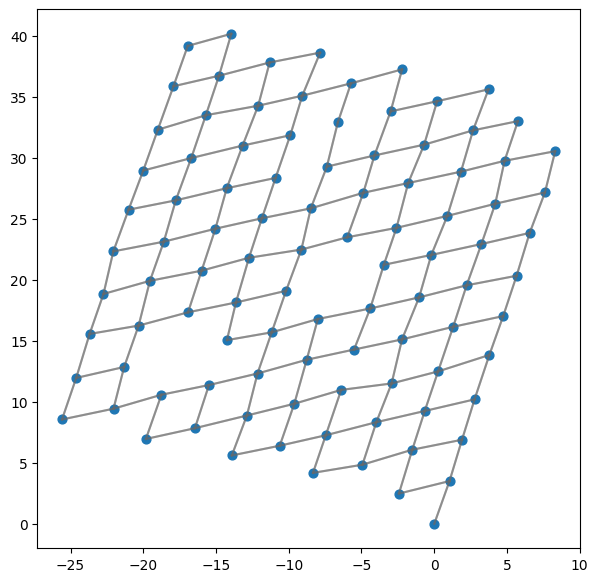

In [15]:
type_ = "hexagonal"
id_ = 10
graph = np.load(f"../GenData/{type_}/{type_}_{id_}.npz")
node_values = graph["nodes"]
edge_values = graph["edges"]
adj_list = graph["adj_list"]
pos = graph["positions"]
draw_graph(adj_list, pos, axis=True, node_size=40)

dat = graphToData(f"../GenData/{type_}/{type_}_{id_}.npz")
model.eval()
with torch.no_grad():
    dat = dat.to(device)
    pred = model(dat)
    print("predicition: ", pred)
    print("label: ", dat.y)